# Seasonal lags to capture seasonality

In this notebook we will show how we can use seasonal lags to try and capture seasonality. 

In [1]:
import re
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

sns.set_context("talk")

# Data set synopsis

The air passengers dataset is the monthly totals of international airline passengers, from 1949 to 1960, in units of 1000s. 

For instructions on how to download, prepare, and store the dataset, refer to notebook number 5, in the folder "01-Create-Datasets" from this repo.

# Load data

In [7]:
df = pd.read_csv(
    "../Datasets/example_air_passengers.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)

## Plot the data

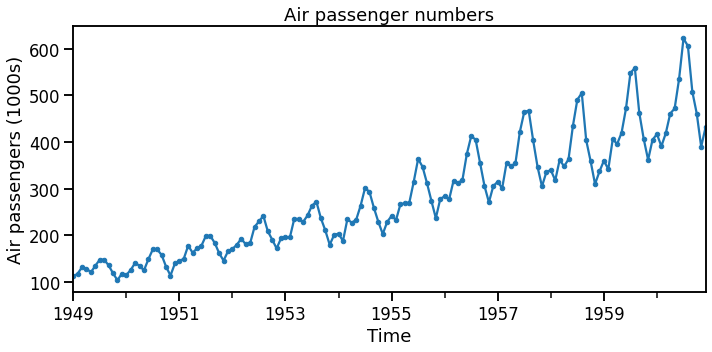

In [8]:
fig, ax = plt.subplots(figsize=[10, 5])
df.plot(y="y", marker=".", figsize=[10, 5], legend=None, ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers (1000s)")
ax.set_title("Air passenger numbers")
plt.tight_layout()

# Forecasting with seasonal lag features

For this problem we know that there is yearly seasonality. So perhaps using a lag feature of 12 months can help us capture the seasonality. See the Lag features section of the course and the notebooks in `07-Lag-Features` for more information around using the various methods to identify potential seasonal lags when we don't know what seasonality to use.

Let's build a recursive forecast and see how we can include datetime features in our feature engineering pipeline.

In [9]:
# --- The transformers from earlier in the course. --- #
# Lag and window features
from sktime.transformations.series.summarize import WindowSummarizer
# Time features for trend 
from sktime.transformations.series.time_since import TimeSince
from sklearn.preprocessing import PolynomialFeatures
# Rescaling transformer for linear models with regularisation
from sklearn.preprocessing import MinMaxScaler
# Pipelines to create feature engineering pipeline
from sklearn.pipeline import make_pipeline, make_union
# Used to reset sklearn estimators
from sklearn.base import clone

# Let's ensure all sklearn transformers output pandas dataframes
from sklearn import set_config
set_config(transform_output="pandas")  # Upgrade to scikit-learn >= 0.12
                                       # for this feature

In [10]:
df = data.copy()
df.head()

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Specify target name.

In [12]:
target=["y"] # Note: it's in a list.
                  # This ensures we'll get
                  # a dataframe when using df.loc[:, target]
                  # rather than a pandas Series. 
                  # This can also be useful if we have
                  # multiple targets.

Prepare our transformers.

In [47]:
# Polynomial time features for trend
time_feats = make_pipeline(
                           TimeSince(), 
                           PolynomialFeatures(degree=2, include_bias=False)
                          )


# Compute lag and window features.
lag_window_feats = WindowSummarizer(
    lag_feature={
        "lag": [1, 12],  # Just using the previous lag and a seasonal lag
    },
    target_cols=target,
    truncate="bfill",  # Backfill missing values from lagging and windowing.
)

Create a pipeline to create all our features.

In [48]:
# To see how the datetime features help
# try commenting them out and just using
# lag features, then try just using datetime
# features.
pipeline = make_union(
    time_feats, 
    lag_window_feats,
)

# Apply min-max scaling to all the features
pipeline = make_pipeline(pipeline, MinMaxScaler())

In [49]:
pipeline

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline',
                                                 Pipeline(steps=[('timesince',
                                                                  TimeSince()),
                                                                 ('polynomialfeatures',
                                                                  PolynomialFeatures(include_bias=False))])),
                                                ('windowsummarizer',
                                                 WindowSummarizer(lag_feature={'lag': [1,
                                                                                       12]},
                                                                  target_cols=['y'],
                                                                  truncate='bfill'))])),
                ('minmaxscaler', MinMaxScaler())])

Let's check how our feature engineering pipeline behaves.

In [50]:
pipeline.fit_transform(df.head())

/Users/kishan_manani/.pyenv/versions/3.8.7/envs/udemy-ts/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/kishan_manani/.pyenv/versions/3.8.7/envs/udemy-ts/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


,time_since_1949-01-01 00:00:00,time_since_1949-01-01 00:00:00^2,y_lag_1,y_lag_12
ds,,,,
1949-01-01,0.00,0.0000,0.00,NaN
1949-02-01,0.25,0.0625,0.00,NaN
1949-03-01,0.50,0.2500,0.30,NaN
1949-04-01,0.75,0.5625,1.00,NaN
1949-05-01,1.00,1.0000,0.85,NaN


Let's reset our feature engineering pipeline.

In [51]:
# We can use `clone` to return an unfitted version
# of the pipeline.
pipeline = clone(pipeline)

Let's build a recursive forecast.

We'll start with configuring the model, the forecast start time, the number of steps to forecast, and the forecasting horizon, and the model.

In [52]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor

In [53]:
# --- CONFIG --- #
# Define time of first forecast, this determines our train / test split.                                              
forecast_start_time = df.index.max() - pd.DateOffset(months=36) # Start 3 years from the end.

# Define number of steps to forecast.
num_of_forecast_steps = 12*3 # 3 years into the future

# Define the model.
model = LinearRegression()

# Create a list of periods that we'll forecast over.
forecast_horizon = pd.date_range(forecast_start_time, 
                                   periods=num_of_forecast_steps,
                                   freq="MS")

# How much data in the past is needed to create our features
look_back_window_size = pd.DateOffset(weeks=1) # We need the latest 24*7 time periods
                                             # in our predict dataframe to build our 
                                             # window features.

Let's create our training dataframe.

In [54]:
# --- CREATE TRAINING & TESTING DATAFRAME  --- #
# Ensure we only have training data up to the start
# of the forecast.
df_train = df.loc[df.index < forecast_start_time].copy()
df_test = df.loc[df.index >= forecast_start_time].copy()

Let's prepare the dataframe that we will pass to `model.predict()`. This will contain some portion of time series during the training period so we can create any features that require historic data.

In [55]:
# --- FEATURE ENGINEERING--- #
# Create X_train and y_train
y_train = df_train[target]
X_train = pipeline.fit_transform(df_train)

# LightGBM cannot handle column names which have
# certain characters (e.g., ":"). We replace these
# with `_`. 
if "lightgbm" in model.__module__: # checks if model is from lightgbm
    X_train = X_train.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "_", x))


# --- MODEL TRAINING---#
# Train one-step ahead forecast model
model.fit(X_train, y_train)

LinearRegression()

In [56]:
# --- CREATE DYNAMIC PREDICTION DATAFRAME  --- #
# We will recursively append our forecasts to this 
# dataframe and re-compute our lag and window features from the
# target in this dataframe. It contains data in both the training period 
# and forecast period which is needed for some transformers (e.g., lags and windows).
look_back_start_time = forecast_start_time - look_back_window_size

# Create `df_predict` which has data going as far back
# as needed to create features which need past values.
df_predict = df_train.loc[look_back_start_time:].copy()

# Extend index into forecast horizon
df_predict = pd.concat([
                  df_predict,
                  pd.DataFrame(index=forecast_horizon)
                 ])

Let's compute our `X_train` and `y_train` and fit our model!

Let's recursively create `X_test` and make our predictions and append them to the `df_predict` dataframe.

In [57]:
# --- RECURSIVE FORECASTING LOOP --- #
for forecast_time in forecast_horizon:    
    # Compute features during the forecast horizon
    X_test = pipeline.transform(df_predict)
    X_test = X_test.loc[[forecast_time]] 

    # Predict one step ahead. 
    y_pred = model.predict(X_test)
    
    # Append forecast to the target variable columnn in our
    # dynamic forecast dataframe `df_predict`. This `df_predict`
    # is ready for the next iteration where we will re-compute
    # features derived from the target such as lags and windows.
    df_predict.loc[[forecast_time], target] = y_pred

Let's retrieve our forecast and actuals during the forest horizon.

In [58]:
# --- GET FORECAST AND TEST VALUES --- #    
y_forecast = df_predict.loc[forecast_horizon, target]
y_test = df_test.loc[forecast_start_time:, target]

Let's create predictions on the training set using our one step ahead forecast model. This is useful to plot when debugging models.

In [59]:
# --- CREATE IN-SAMPLE PREDICTIONS--- #
y_forecast_train = model.predict(X_train)
y_forecast_train = pd.DataFrame(y_forecast_train, index=X_train.index, columns=target)

Let's plot the forecast!

Text(0.5, 1.0, 'Forecast with LinearRegression()')

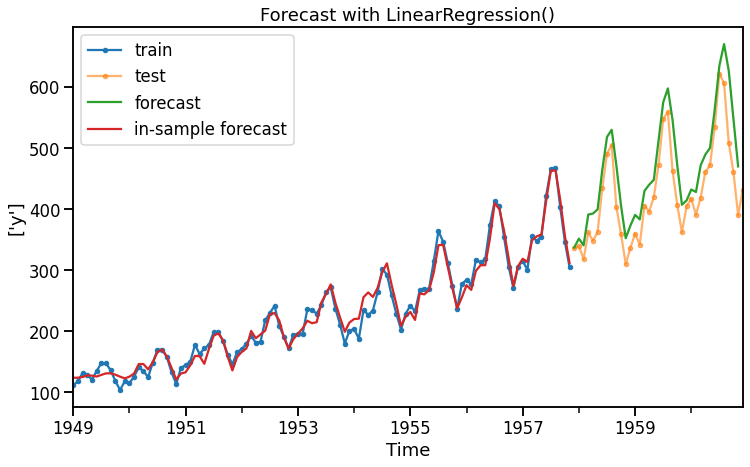

In [60]:
# --- PLOTTING --- #
# Plot the forecast.
fig, ax = plt.subplots(figsize=[12, 7])

# Plot training set.
y_train.plot(ax=ax, marker='.')
# Plot actuals in forecasting horizon.
y_test.plot(ax=ax, marker='.', alpha=0.6)
# Plot forecast.
y_forecast.plot(ax=ax)
# Plot 1 step forecasts in training data.
y_forecast_train.plot(ax=ax)

ax.legend(["train", "test", "forecast", "in-sample forecast"])
ax.set_xlabel("Time")
ax.set_ylabel(f"{target}")
ax.set_title(f"Forecast with {model}")

Let's compute the RMSE of this forecast.

In [61]:
# Compute error metrics.
from sklearn.metrics import mean_squared_error
mean_squared_error(y_true=y_test.loc[y_forecast.index],
                   y_pred=y_forecast,
                   squared=False)

46.87136907684174

Feel free to change the dates, try different models, and different features!

In this notebook we have shown that seasonal lags can help capture seasonality. In lectures we showed that seasonal lags do not always capture the seasonality well, for example, try using just seasonal lags with the Electricity Demand in Victoria dataset as we showed in lectures. Seasonal lags don't explicitly capture how seasonal aspects of the calendar (e.g., the months of the year) introduce seasonal effects. So let's look at some other ways to capture seasonality in the following lectures and notebooks!